# Исследование надёжности заёмщиков

**Цель:** нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. 

**Заказчиком** исследования является кредитный отдел банка. 

**Входные данные от банка** — статистика о платёжеспособности клиентов. О качестве данных ничего не известно. Поэтому перед выявлением закономерностей понадобится обзор данных, а так же проверка данных на ошибки и оценка их влияния на исследование.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Ожидается, что исследование поможет ответить на следующие вопросы:
* Есть ли зависимость между наличием детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?

Таким образом, исследование пройдёт в четыре этапа:
1. Обзор данных.
2. Предобработка данных.
3. Поиск зависимостей.
4. Основные выводы.

## Шаг 1. Откроем файл с данными и изучим общую информацию

Путь к файлу с данными: `/datasets/data.csv`. 

Чтобы работать с `.csv`-файлом подгружаем библиотеку `pandas`. 

Так же для дальнейшей работы нам понадобится ряд других библиотек:
- `numpy` - для удобной работы с некоторыми встроенными функциями,
- `pymystem` - для лемматизации данных,
- `collections` - для подсчета лемматизированных данных
- `matplotlib` - для работы с графиками.

In [1]:
# импорт библиотеки pandas
import pandas as pd

# импорт библиотеки numpy
import numpy as np

# импорт модуля Mystem библиотеки pymystem3
from pymystem3 import Mystem
m = Mystem()

# импорт модуля Counter библиотеки collections
from collections import Counter

# импорт модуля pyplot из библиотеки matplotlib
from matplotlib import pyplot as plt

Читаем `.csv`-файл и сохраняем его в переменную `df`. Используем блоки `try - except` на случай, если файл будет поврежден, перемещён и т.д.

In [2]:
# чтение файла с данными и сохранение в df
try:
    df = pd.read_csv('/datasets/data.csv')
except Exception as err:
    try:
        df = pd.read_csv('data.csv')
    except Exception as err:
        print('Ошибка чтения файла:', repr(err))

In [3]:
# получение первых 10 строк таблицы df
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [4]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В таблице 21525 строк, соответствующих клиентам банка, и 12 столбцов.

**Описание данных cогласно документации:**
* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

**Вывод**

**В каждой строке таблицы** — данные о клиенте банка. 
Часть колонок описывает самого клиента: возраст, пол, уровень образования, семейный статус и количество детей. 
Остальные данные рассказывают о пользователе с финансовой точки зрения: ежемесячный доход, трудовой стаж, цель получения кредита, а так же есть ли по нему задолженность. 

В таблице двенадцать столбцов. Можно сразу отметить, что:

* Тип данных в столбцах — `object`, `int64` и `float64`. Для экономии памяти можно изменить тип данных в столбцах, содержащих числовые данные.
* В названии колонок нет нарушения стиля.
* Количество значений в столбцах различается. В данных столбцов `days_employed` и `total_income` есть пропущенные значения.
* В колонке `days_employed` присутствуют отрицательные значения. Это противоречит возможным срокам трудового стажа (стаж исчисляется днями и может быть либо нулём, либо положительным значением величиной , не превышающей трудоспособного возраста человека в днях), что свидетельствует об ошибке в данных.
* Сразу видны дубликаты в колонке `education` с разным регистром: СРЕДНЕЕ, Среднее и среднее, которые нужно привести к единому стилю.
* Для удобства работы с таблицей из неё можно исключить колонки `education` и `family_status`, поместив их в отдельные таблицы и создав словари для значений `education_id` и `family_status_id` соответственно.
* Так же бросаются в глаза высокие доходы 53-летней бездетной пенсионерки с 932-летним трудовым стажем, желающей сыграть свадьбу, из строчки с индексом 4. Ведь задолженности по выплате кредита у неё не было.

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но встречаются пропуски в данных и некорректные значения.


## Шаг 2. Предобработка данных

### Обработка пропусков

Посчитаем, сколько в таблице пропущенных значений.

In [5]:
# подсчёт пропусков
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Больше _двух тысяч пропусков_ в колонках с трудовым стажем и ежемесячным доходом. Возможно, при записи данных или их выгрузке произошёл сбой, так как кредитный отдел банка не мог не запросить такую информацию от клиентов, а клиенты не могли отказаться её предоставить. 

Эти пропуски не должны повлиять на исследование, так как главной целью является проверка влияет ли _семейное положение_ и _количество детей_ клиента на факт погашения кредита в срок. Будь это категориальные данные, стоило бы заполнить пропуски в колонках явным обозначением `unknown`, но пропуски должны быть заполнены числами, если колонка содержит числа. При выборе такой тактики стоит учесть, что это может помешать корректно ответить на вопрос о зависимости между уровнем дохода и возвратом кредита в срок.

#### Пропуски
Взглянем на данные с пропусками. 
Для этого создадим таблицу `df_nan`, оставив в ней только клиентов с пропусками в колонке с трудовым стажем.

In [6]:
# создание таблицы с пропусками в колонке трудового стажа
df_nan = df[df['days_employed'].isna()]
df_nan.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


In [7]:
# получение общей информации о данных в таблице df_none
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          2174 non-null   int64  
 1   days_employed     0 non-null      float64
 2   dob_years         2174 non-null   int64  
 3   education         2174 non-null   object 
 4   education_id      2174 non-null   int64  
 5   family_status     2174 non-null   object 
 6   family_status_id  2174 non-null   int64  
 7   gender            2174 non-null   object 
 8   income_type       2174 non-null   object 
 9   debt              2174 non-null   int64  
 10  total_income      0 non-null      float64
 11  purpose           2174 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


#### Значения трудового стажа
Более двух тысяч клиентов имеют пропуски и в колонке с трудовым стажем, и в колонке с ежемесячным доходом. 
Рассмотрим подробнее, какие значения трудового стажа имеют клиенты без пропуска в данной колонке.

In [8]:
# Просмотр информации из столбца общего трудового стажа
df['days_employed'].describe()

count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

Мы видим, что в этом столбце много проблем.

*Отрицательные значения*, возможно, появились случайно и на самом деле являются положительными, а может это некорректно сохраненные или выгруженные данных, не имеющие никакого отношения к реальному стажу клиентов. Так же стоит отметить, что *максимальное значение* стажа в 401755 дней соответствует 1100 годам. Возможно, это говорит о том, что некоторые данные в столбце представлены не в днях, как заявлено в описании к данным, а, например, в часах.

Оценим количество отрицательных значений трудового стажа.

In [9]:
# Посчет отрицательных значений трудового стажа
df[df['days_employed'] <= 0]['days_employed'].count()

15906

Рассчитаем процентое соотношение отрицательных значений ко всем значениям трудового стажа.

In [10]:
print('Отрицательных значений трудового стажа {:.0%}'.format(
    df[
        (df['days_employed'] <= 0) & 
        (df.days_employed.isna() != True)
    ]
    ['days_employed'].count() / df['days_employed'].count()))

Отрицательных значений трудового стажа 82%


Ознакомимся со статистикой по отрицательным значениям трудового стажа.

In [11]:
df[df['days_employed'] <= 0]['days_employed'].describe()

count    15906.000000
mean     -2353.015932
std       2304.243851
min     -18388.949901
25%      -3157.480084
50%      -1630.019381
75%       -756.371964
max        -24.141633
Name: days_employed, dtype: float64

По данным можно сделать вывод, что значения были записаны как отрицательные вследствие ошибки. Рассмотрим данные некоторых клиентов поподробнее.

In [12]:
# Выведем часть таблицы, отсортированной по возрастанию отрицательных значений трудового стажа
df[df.days_employed < 0].sort_values(by='days_employed').head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
16335,1,-18388.949901,61,среднее,1,женат / замужем,0,F,сотрудник,0,186178.934089,операции с недвижимостью
4299,0,-17615.563266,61,среднее,1,женат / замужем,0,F,компаньон,0,122560.741753,покупка жилья
7329,0,-16593.472817,60,высшее,0,женат / замужем,0,F,сотрудник,0,124697.846781,заняться высшим образованием
17838,0,-16264.699501,59,среднее,1,женат / замужем,0,F,сотрудник,0,51238.967133,на покупку автомобиля
16825,0,-16119.687737,64,среднее,1,женат / замужем,0,F,сотрудник,0,91527.685995,покупка жилой недвижимости


Если предположить, что знак минус появился в значениях *по ошибке*, то для сотрудника из 16335 строки получится 50 лет трудового стажа при возрасте в 61 год. *Данные не похожи на реальные*, если только для этого клиента не был засчитан стаж на каком-нибудь вредном или опасном производстве, где год стажа считается за два. Такой информации у нас нет, а клиент с нереалистичным стажем в таблице не один. 
Так же взглянем на клиентов с максимальными из отрицательных значений трудового стажа.

In [13]:
# Выведем часть таблицы, отсортированной по убыванию отрицательных значений трудового стажа
df[df.days_employed < 0].sort_values(by='days_employed', ascending=False).head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
17437,1,-24.141633,31,среднее,1,женат / замужем,0,F,сотрудник,1,166952.415427,высшее образование
8336,0,-24.240695,32,высшее,0,Не женат / не замужем,4,M,сотрудник,0,124115.373655,получение дополнительного образования
6157,2,-30.195337,47,среднее,1,гражданский брак,1,M,компаньон,0,231461.185606,свадьба
9683,0,-33.520665,43,среднее,1,Не женат / не замужем,4,M,сотрудник,1,128555.897209,приобретение автомобиля
2127,1,-34.701045,31,высшее,0,женат / замужем,0,F,компаньон,0,90557.994311,получение образования


Если перевести значения трудового стажа в положительные, они тоже не кажутся реальными - слишком маленький трудовой стаж для людей старше 30 лет.

Делаем **вывод**, что отрицательные значения трудового стажа использовать в рассчетах нельзя без уточнения формата, в котором они сохранены.

Так же оценим количество значений, превышающих 55 лет трудового стажа (>20075 дней в таблице).

In [14]:
# Посчет значений трудового стажа свыше 55 лет
df[df['days_employed'] > 20075]['days_employed'].count()

3445

Рассчитаем процентное соотношение трудового стажа, превышающего 55 лет, ко всем значениям.

In [15]:
print('Значений трудового стажа свыше 55 лет {:.0%}'.format(df[df['days_employed'] > 20075]['days_employed'].count()/df.days_employed.count()))

Значений трудового стажа свыше 55 лет 18%


Ознакомимся с положительными значениями трудового стажа.

In [16]:
# Статистика по положительным значениям трудового стажа
df[df['days_employed'] > 20075]['days_employed'].describe()

count      3445.000000
mean     365004.309916
std       21075.016396
min      328728.720605
25%      346639.413916
50%      365213.306266
75%      383246.444219
max      401755.400475
Name: days_employed, dtype: float64

Больше похоже, что положительные значения трудового стажа представлены не в днях, а в часах.

**Вывод**

Все значения **колонки с трудовым стажем** *не соответсвуют заявленным*: 82% - отрицательный стаж, и 18% - представлены в часах.
Так как значения трудового стажа не являются ключевыми данными для ответа на поставленные для исследования вопросты, предположим, что данную колонку можно исключить из исследования без существеннх потерь для самого исследования.

In [17]:
# Удаляем колонку 'days_employed' из таблицы df
df.drop(columns = ['days_employed'], axis = 1, inplace=True)

In [18]:
# Убедимся, что колонка действительно удалена
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


#### Колонка с возрастом
Во время работы с колонкой стажа, приходилось опираться на колонку с возрастом.
Посмотрим, клиенты какого возраста представлены в таблице.

In [19]:
# Просмотр уникальных значений возраста клиентов
df['dob_years'].sort_values().unique()

array([ 0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75], dtype=int64)

В колонке с возрастом так же произошёл сбой при записи или выгрузке данных, либо оператор опечатался при вводе.
Посчитаем клиентов с нулевым возрастом.

In [20]:
# Подсчёт количества клиентов с нулевым возрастом
df[df['dob_years'] == 0]['dob_years'].count()

101

Сто один клиент без возраста. Оценим, клиенты какого возраста чаще всего брали кредит.

In [21]:
# среднее и медианное значение возраста клиентов
print('Среднее значение возраста клиентов: {:.0f}\nМедианное значение возраста клиентов:{:.0f}'.format(
    df['dob_years'].mean(),
    df['dob_years'].median()))

Среднее значение возраста клиентов: 43
Медианное значение возраста клиентов:42


Средний и  медианный возраст клиентов без утерянных данных - чуть старше сорока лет.

Восстановить возраст пропущенных значений постараемся с учётом типа занятости клиентов.

Начнем с того, что посмотрим все <a id='income_type'>**уникальные значения для типа занятости**</a>.

In [22]:
# Просмотр уникальных значений типа занятости клиентов
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

Восемь уникальных типов занятости клиентов, дубликаты отсутствуют, колонка содержит корректные данные.

Взглянем, чем занимаются клиенты с нулевым возрастом.

In [23]:
# Тип занятости клиентов с нулевым возрастом
df[df['dob_years'] == 0]['income_type'].unique()

array(['пенсионер', 'сотрудник', 'компаньон', 'госслужащий'], dtype=object)

Зная тип занятости клиентов, можно оценить их возраст - присвоим клиентам среднее значение возраста в их категории: *пенсионеры* и *работающие* клиенты.

Подсчитаем средний возраст клиентов *пенсионного* возраста.

In [24]:
# Средний возраст клиентов пенсионного возраста
pensioner_age = int(round(df[df['income_type'] == 'пенсионер']['dob_years'].mean()))
pensioner_age

59

Напишем функцию для замены возраста в таблице. Функция `change_age` принимает `list_of_types` - список типов занятости клиентов с нулевым значением возраста, и `age` - возраст, на который нужно заменить нулевое значение.

Для того, чтобы заменить возраст клиента в строке с нулевым значением, воспользуемся методом библиотеки `numpy` `logical_and`, позволяющей выбрать одновременно значение `0` в колонке `dob_years`, и желаемое значение занятости в колонке `income_type`.

In [25]:
def change_age(list_of_types, age):
    '''
    Функция для замены возраста в таблице
    list_of_types - список типов занятости клиентов с нулевым значением возраста, 
    age - возраст, на который нужно заменить нулевое значение
    '''
    for type in list_of_types:
        df.loc[np.logical_and(df['dob_years'] == 0, df['income_type'] == type), 'dob_years'] = age

In [26]:
# Заменим нулевые значения возраста клиентов-пенсионеров на среднее значение возраста в данной категории
change_age(['пенсионер'], pensioner_age)

Для *работающих* клиентов подсчитаем средний возраст, исключив всех безработных, пенсионеров и студентов.

In [27]:
# Средний возраст работающих клиентов
working_age = np.round(df[(df['income_type'] != 'пенсионер') & (df['income_type'] != 'безработный') & (df['income_type'] != 'студент')]['dob_years'].mean())
working_age

40.0

Заменим возраст *работающих* клиентов в строчках с нулевым значением на средний возраст среди работающих клиентов - 40 лет.

In [28]:
# Заменим нулевые значения возраста работающих клиентов на среднее значение возраста в данной категории
change_age(['сотрудник', 'компаньон', 'госслужащий'], working_age)

Проверим, не осталось ли нулевых значений возраста в таблице.

In [29]:
# Проверка уникальных значений возраста
df['dob_years'].sort_values().unique()

array([19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31.,
       32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44.,
       45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56., 57.,
       58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70.,
       71., 72., 73., 74., 75.])

**Вывод**

Нулевое значение возраста клиентов было заменено на среднее значение возраста в зависимости от того, работает клиент или нет.

#### Колонка с ежемесячным доходом
Прежде чем приступить к заполнению пропусков в колонке с ежемесячным доходом, проверим её на корректность.

In [30]:
# Просмотр статистики по колонке с ежемесячным доходом клиентов
df['total_income'].describe()

count    1.935100e+04
mean     1.674223e+05
std      1.029716e+05
min      2.066726e+04
25%      1.030532e+05
50%      1.450179e+05
75%      2.034351e+05
max      2.265604e+06
Name: total_income, dtype: float64

In [31]:
# Просмотр медианного значения колонки с ежемесячным доходом клиентов
df['total_income'].median()

145017.93753253992

В колонке нет нереалистичных значений. Разброс в доходах достаточно большой.
* Средний доход клиентов составляет 167 тысяч. 
* Медиана - 145 тысяч.
* Минимальный доход клиента составил 20 тысяч.
* Максимальный доход клиента - 2 миллиона 265 тысяч. 

Чтобы заполнить пропуски в колонке с ежемесячным доходом будем ориентироваться [на тип занятости клиента](#income_type). Выше она была проверена на корректность. 

Обновим значения в таблице `df_nan` и посмотрим, чем занимаются клиенты с пропущенным доходом

In [32]:
# Обновление таблицы с пропущенными значениями и вывод её первых строк
df_nan = df[df['total_income'].isna()]
df_nan.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,65.0,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,41.0,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,63.0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,50.0,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,54.0,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


In [33]:
# Просмотр уникальных значений типов занятости клиентов с пропущенными значениями ежемесячного дохода
types_of_nan_income = df_nan['income_type'].unique()
types_of_nan_income

array(['пенсионер', 'госслужащий', 'компаньон', 'сотрудник',
       'предприниматель'], dtype=object)

Видим, что у нас 5 разных типов занятости с пропущенными значениями.

Чтобы проверить пропуски на случайность, было решено проверить их на независимость от значений в других столбцах. Для этого посмотрим на распределение значений для среза с пропусками и сравним его с таким же распределением для среза без пропусков.
Таблица с пропусками `df_nan` у нас уже имеется, создадим таблицу без пропусков `df_no_nan`.

In [34]:
df.head(0)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


In [35]:
# таблица без пропусков
df_no_nan = df[~df['total_income'].isna()]

Далее напишем функцию `nan_dependence` для быстрой оценки зависимости пропусков от данных других столбцов. Данная функция принимает на входе значение колонки `column`, для которой будет осуществлена проверка на зависимость пропусков и возвращает таблицу с распределением в долях каждого значения из колонки `column` в таблице с пропусками и в таблице без пропусков.

In [36]:
def nan_dependence(column):
    # создаем датафрейм с распределением в долях каждого значения в таблице с пропусками 
    df_table1 = pd.DataFrame(df_nan[column].value_counts(normalize=True))
    # создаем датафрейм с распределением в долях каждого значения в таблице без пропусков
    # и только по значениям, которые есть в таблице с пропусками, используя индексы из df_table1 
    df_table2 = pd.DataFrame(df_no_nan[df[column].isin(df_table1.index)][column].value_counts(normalize=True))
    # объединяем таблицы в одну по индексам
    df_table_income = df_table1.merge(df_table2, right_index=True, left_index=True, how='outer', suffixes=('_with_nan', '_without_nan'))
    return df_table_income


Взглянем на её работу функции.

In [37]:
nan_dependence('children')

<ipython-input-36-d574adcd52e1>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_table2 = pd.DataFrame(df_no_nan[df[column].isin(df_table1.index)][column].value_counts(normalize=True))


,children_with_nan,children_without_nan
-1,0.001380,0.002274
0,0.661914,0.656814
1,0.218491,0.224433
2,0.093836,0.095654
3,0.016559,0.015193
4,0.003220,0.001757
5,0.000460,0.000413
20,0.004140,0.003462


`UserWarning` печалит, но эта функция делает ровно то, что было задумано: функция вернула таблицу с распределениями значений количества детей для данных с пропусками `children_with_nan` и `children_without_nan`. 

Далее для наглядности выводить таблицу уже не будем, а используем столбчатую диаграмму. Для ускорения работы используем функцию `show_plot`, принимающую в себя колонку, для которой хотим посмотреть распределение `column` и название категорий, для которых сравниваем значения `xlab`.

In [38]:
# Функция для отрисовки столбчатой диаграммы
def show_plot(column, xlab, rot=0):
    
    nan_dependence(column).plot(kind='bar', figsize=(14, 4), rot=rot, title='Распределение значений для данных с пропусками и без').set(xlabel=xlab,
         ylabel='доли')

Далее визуально оценим диаграммы зависимостей пропусков в данных от отстальных столбцов в колонке.

<ipython-input-36-d574adcd52e1>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_table2 = pd.DataFrame(df_no_nan[df[column].isin(df_table1.index)][column].value_counts(normalize=True))


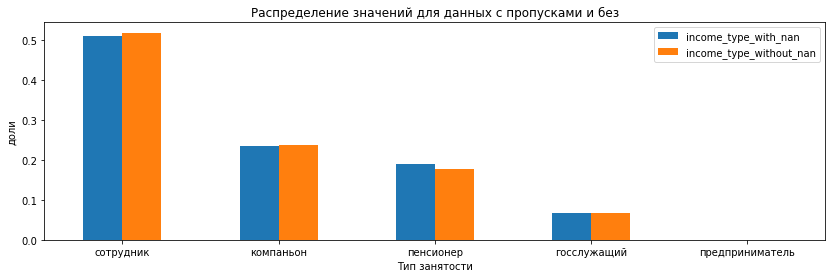

In [39]:
# Показать диаграмму зависимости пропуска от колонки income_type
show_plot('income_type', 'Тип занятости')

Исходя из графика, нельзя выявить какую-то явную зависимость в распределении пропусков исходя из типов занятости клиентов.

<ipython-input-36-d574adcd52e1>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_table2 = pd.DataFrame(df_no_nan[df[column].isin(df_table1.index)][column].value_counts(normalize=True))


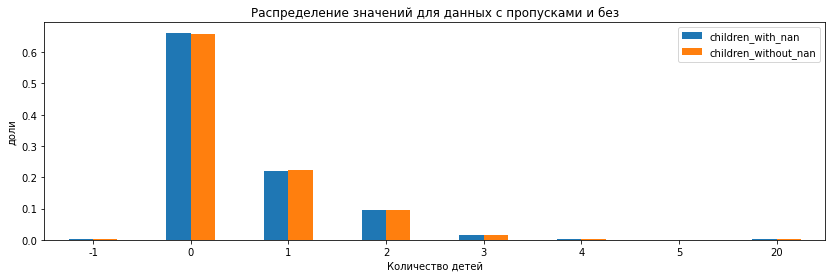

In [40]:
# Показать диаграмму зависимости пропуска от колонки children
show_plot('children', 'Количество детей')

Видим, что зависимости пропусков от количества детей нет, а данные в ошибках есть. Осознанно не заменяем их сразу, так как подобные ошибки могут так же коррелировать с количеством пропусков.

<ipython-input-36-d574adcd52e1>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_table2 = pd.DataFrame(df_no_nan[df[column].isin(df_table1.index)][column].value_counts(normalize=True))


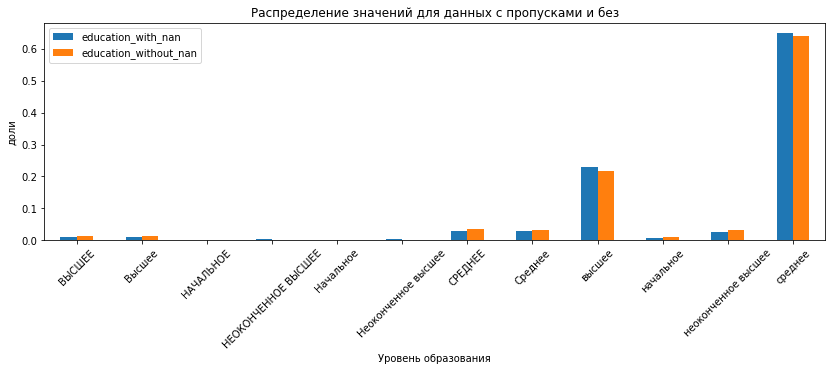

In [41]:
# Показать диаграмму зависимости пропуска от колонки education
show_plot('education', 'Уровень образования', rot=45)

По аналогии с предыдущей диаграммой видим, что зависимости пропусков от уровня образования нет, а данные в ошибках есть. Возможно, разные операторы использовали разный регистр.

<ipython-input-36-d574adcd52e1>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_table2 = pd.DataFrame(df_no_nan[df[column].isin(df_table1.index)][column].value_counts(normalize=True))


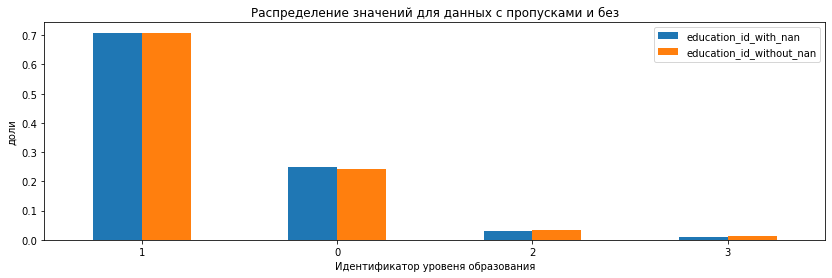

In [42]:
# Показать диаграмму зависимости пропуска от колонки education_id
show_plot('education_id', 'Идентификатор уровеня образования')

Зависимости пропусков от индентификатора уровня образования так же нет, а данные в ошибках есть.

<ipython-input-36-d574adcd52e1>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_table2 = pd.DataFrame(df_no_nan[df[column].isin(df_table1.index)][column].value_counts(normalize=True))


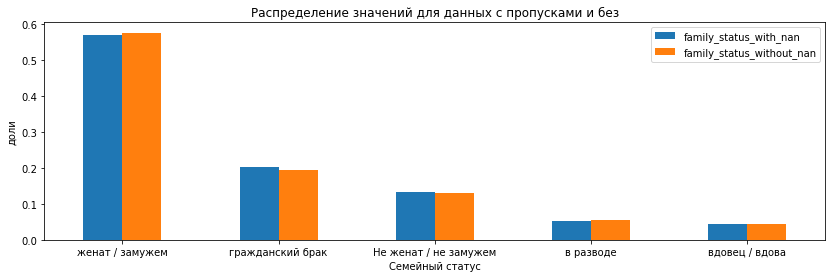

In [43]:
# Показать диаграмму зависимости пропуска от колонки family_status
show_plot('family_status', 'Семейный статус')

Зависимость от семейного статуса не найдена.

<ipython-input-36-d574adcd52e1>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_table2 = pd.DataFrame(df_no_nan[df[column].isin(df_table1.index)][column].value_counts(normalize=True))


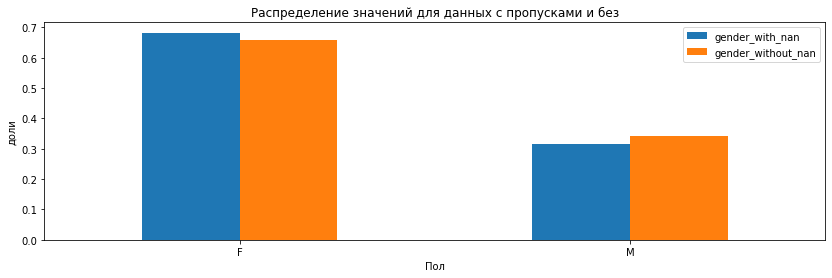

In [44]:
# Показать диаграмму зависимости пропуска от колонки gender
show_plot('gender', 'Пол')

Зависимость от пола клиента не найдена. Это был последний столбец, который мы хотели проверить, поэтому можно считать **пропуски в данных случайными**.

Далее для клиентов каждого типа занятости заменим пропуски на **медианное значение ежемесячного дохода**. Медианное значение выбираем для сокращения влияния данных, сильно выбивающихся из общей массы.

In [45]:
# Заменяем пропуски в значениях на медианные значения
df['total_income'] = df.groupby('income_type')['total_income'].transform(lambda x : x.fillna(x.median()))

Проверим, что формула отработала, как и задумано. Для этого опять подсчитаем количество пропущенных значений в таблице.

In [46]:
# подсчёт пропусков
df.isna().sum()

children            0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**

Пропуски в колонке с ежемесячным доходом были заполнены медианным значением с учётом типа занятости клиентов. На этом явные пропуски в таблице закончены.

### Неявные пропуски

Пропуски в таблице могут быть не только явными: `None` и `NaN`. При заполнении таблицы так же могли использоваться и неявные обозначения типа `'None'`, `'no data'` и многие другие, которые не могут быть выявлены методом `.isna()`. Чтобы ничего не упустить, проверим каждый из оставшихся столбцов.

Подробно рассмотрим содержание каждого столбца.

#### Колонка с количеством детей

In [47]:
# Просмотр уникальных значений количества детей в семье
df['children'].sort_values().unique()

array([-1,  0,  1,  2,  3,  4,  5, 20], dtype=int64)

В значениях есть проблемы: -1 и 20 детей, появившиеся, возможно, в результате опечатки оператора банка во время ввода данных или во время автозамены в таблице. Скорее всего это 1 и 2 детей соответственно.

In [48]:
# Замена значений в столбце с количеством детей
df['children'] = df['children'].replace({20: 2, -1: 1})

Убедимся, что данные в колонке изменены.

In [49]:
# Проверка уникальных значений колонки с количеством детей
df.children.sort_values().unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

**Вывод**

В колонке заменены ошибочные значения детей -1 и 20 на 1 и 2 соответственно.

#### Колонка с семейным статусом и колонка с идентификатором семейного статуса

In [50]:
# Просмотр уникальных значений семейного статуса клиентов
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

В значениях семейного статуса есть отклонения от единообразия стиля - сочетание заглавных и строчных букв, и отсутствуют дубликаты. Всего пять уникальных значений семейного статуса. Исправим отклонения в стиле.

In [51]:
# Изменение сочетания заглавных и строчных букв
df['family_status'] = df['family_status'].str.lower()
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

In [52]:
# Просмотр уникальных значений идентификатора семейного статуса клиентов
df['family_status_id'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

Пять значений идентификатора совпадают с количеством уникальных значений семейного статуса. Данные этой колонки корректны.

**Вывод** 

Значения колонки с семейным статусом приведены к единому стилю.

#### Колонка с полом клиентов

In [53]:
# Просмотр уникальных значений пола клиентов
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

В колонке с полом клиента существуют пропуски, так как кредитный отдел банка вряд ли бы выделил небинарных личностей в отдельную категорию. Подсчитаем количество пропусков.

In [54]:
# Подсчет количества пропусков в колонке с полом клиентов
df[df['gender'] == 'XNA']['gender'].count()

1

Всего один клиент с утерянным значением пола. Взглянем на него, вдруг сможем восстановить его пол по остальным данным.

In [55]:
# Вывод на экран данных по клиенту с неизвестным полом
df[df['gender'] == 'XNA']

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,24.0,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Клиент не в декрете, а значит, восстановить его пол не удалось, заменим его на более распространенный среди клиентов банка. Подсчитаем количество клиенток и клиентов.

In [56]:
# Подсчет клиентов различного пола
print('Количество женщин: {}.'.format(df[df['gender'] == 'F']['gender'].count()))
print('Количество мужчин: {}.'.format(df[df['gender'] == 'M']['gender'].count()))

Количество женщин: 14236.
Количество мужчин: 7288.


Женщин больше почти в два раза, заменим неизвестный пол клиента на женский.

In [57]:
# Замена неизвестного пола на женский
df.loc[df['gender'] == 'XNA', 'gender'] = 'F'
# Проверка колонки с полом клиентов
df['gender'].unique()

array(['F', 'M'], dtype=object)

#### Колонка с задолженностью

In [58]:
# Просмотр уникальных значений колонки с задолженностью
df['debt'].unique()

array([0, 1], dtype=int64)

Столбец содержит только два возможных значения: была ли задолженность по кредиту или нет.

#### Колонка с уровнем образования и колонка с идентификатором уровня образования

In [59]:
# Просмотр уникальных значений уровня образования клиентов
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Клиентами банка являются люди с начальным, средним, неоконченным высшим и высшим образованием и ученой степенью. Всего пять уникальных категорий, однако в колонке много дубликатов. Дубликаты могли появиться в таблице из-за разного формата записи данных разными операторами банка. Приведем их к одному стилю и напишем всё в нижнем регистре.

In [60]:
# Изменение регистра в колонке образования
df['education'] = df['education'].str.lower()
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [61]:
# Просмотр уникальных значений идентификационного номера уровня образованя клиентов
df['education_id'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

Колонка с идентификационными номерами уровня образования соответствует количеству уникальных категорий уровня образования, исходя из чего заключаем, что она содержит корректные значения.

**Вывод**

Колонка с уровнем образования была приведена к единому стилю.

#### Колонка с целью получения кредита
<a id='goals'> </a>

In [62]:
# Просмотр уникальных значений целей получения кредита
df['purpose'].sort_values().unique()

array(['автомобили', 'автомобиль', 'высшее образование',
       'дополнительное образование', 'жилье',
       'заняться высшим образованием', 'заняться образованием',
       'на покупку автомобиля', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля', 'на проведение свадьбы',
       'недвижимость', 'образование', 'операции с жильем',
       'операции с коммерческой недвижимостью',
       'операции с недвижимостью', 'операции со своей недвижимостью',
       'покупка жилой недвижимости', 'покупка жилья',
       'покупка жилья для сдачи', 'покупка жилья для семьи',
       'покупка коммерческой недвижимости', 'покупка недвижимости',
       'покупка своего жилья', 'получение высшего образования',
       'получение дополнительного образования', 'получение образования',
       'приобретение автомобиля', 'профильное образование',
       'ремонт жилью', 'свадьба', 'свой автомобиль',
       'сделка с автомобилем', 'сделка с подержанным автомобилем',
       'строительство 

Видим, что достаточно много дублирующихся по смыслу значений.

**Вывод**

Данная колонка требует лемматизации.

### Замена типа данных

В колонке было произведено много преобразований, взглянем на типы данных в таблице `df` на текущий момент.

In [63]:
# получение общей информации о данных в таблице df
df.dtypes

children              int64
dob_years           float64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object

Видим, что числовые значения представлены двумя типами данных: `int64` и `float64`. Библиотека `pandas` присваивает их по умолчанию. Это требует большего объёма памяти, чем нужно для наших вычислений. 

Например:
`int64` - принимает целое значение от -9223372036854775808 до 9223372036854775807.

Соответственно, для колонок `children`, `dob_years`, `education_id`, `family_status_id` и `debt` хватит памяти, выделяемой для `int8`, принимающего значения от -128 до 127.

А для колонки `total_income` будет достаточно `int32`, принимающего значения от -2147483648 до 2147483647.

Для изменения типа данных выбираем метод `astype()`, потому как он позволяет явно задать желаемый тип данных.

In [64]:
# Замена типа данных int64 на int8
for column in ['children', 'dob_years', 'education_id', 'family_status_id', 'debt']:
    df[column] = df[column].astype('int8')

In [65]:
# Замена типа данных float64 на int32
df['total_income'] = df['total_income'].astype('int32')

Посмотрим, как теперь выглядят типы данных.

In [66]:
# Проверка типов данных 
df.dtypes

children              int8
dob_years             int8
education           object
education_id          int8
family_status       object
family_status_id      int8
gender              object
income_type         object
debt                  int8
total_income         int32
purpose             object
dtype: object

In [67]:
# получение первых 5 строк таблицы df
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


**Вывод**

Сейчас таблица выглядит занимает меньше места в памяти и выглядит чуть аккуратнее из-за целых чисел в ежемесячном доходе клиентов.

### Выделение из таблицы словарей для колонок с уровнем образования и семейным статусом
Для удобства работы с колонкой вынесем дублирующиеся колонки в отдельные таблицы, создав их них подобие словаря. 

Для уровня образования клиентов сохраним в таблицу `df_education` колонки `education` и `education_id`, избавимся от дубликатов и отсортируем по колонке `education_id`.

In [68]:
# Создание таблицы с уровнем образования клиентов
df_education = df[['education_id', 'education']].drop_duplicates().reset_index(drop=True).sort_values(by='education_id')
df_education

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


По аналогии с предыдущей таблицей создаем таблицу `df_family` для колонок с семейным статусом.

In [69]:
# Создание таблицы с семейным статусом клиентов
df_family = df[['family_status_id', 'family_status']].drop_duplicates().reset_index(drop=True).sort_values(by='family_status_id')
df_family

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,не женат / не замужем


Когда таблицы-словари созданы, можем удалить колонки с дублирующими значениями из главной таблицы.

In [70]:
# Удаляем колонки 'education' и 'family_status' из таблицы df
df.drop(columns = ['education', 'family_status'], axis = 1, inplace=True)
# Выводим на экран первые 5 строк обновленной таблицы
df.head()

,children,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,42,0,0,F,сотрудник,0,253875,покупка жилья
1,1,36,1,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,33,1,0,M,сотрудник,0,145885,покупка жилья
3,3,32,1,0,M,сотрудник,0,267628,дополнительное образование
4,0,53,1,1,F,пенсионер,0,158616,сыграть свадьбу


**Вывод**

Из таблицы `df` были созданы две таблицы-словаря для образования `df_education` и семейного статуса `df_family`, а сами эти колонки удалены из главной таблицы.

### Обработка дубликатов

Проверим таблицу `df` на явные дубликаты.

In [71]:
# Подсчёт явных дубликатов в таблице
df.duplicated().sum()

71

В таблице дублируется 71 клиент - они могли появиться при формировании таблицы из разных источников, при случайном продублировании клиентов и т.д. 

Нужно избавиться от повторяющихся данных. Для избавления от явных дубликатов используем метод `.drop_duplicates()` и обновим индексацию методом `.reset_index(drop=True)`.

In [72]:
# Избавление от явных дубликатов
df = df.drop_duplicates().reset_index(drop=True)

In [73]:
# Подсчёт явных дубликатов в таблице
df.duplicated().sum()

0

В таблице не осталось дублирующихся клиентов.

**Вывод**

Строки в таблице теперь представлены только уникальными клиентами.

### Лемматизация

[Выше было обнаружено](#goals), что цели получения кредита у многих клиентов схожи, однако в таблице они прописаны по-разному. 
Сохраним их в переменную `purpose_list` для удобства работы.

In [74]:
# Создание переменной с уникальными значениями целей получения кредита
puprose_list = df['purpose'].sort_values().unique()
puprose_list

array(['автомобили', 'автомобиль', 'высшее образование',
       'дополнительное образование', 'жилье',
       'заняться высшим образованием', 'заняться образованием',
       'на покупку автомобиля', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля', 'на проведение свадьбы',
       'недвижимость', 'образование', 'операции с жильем',
       'операции с коммерческой недвижимостью',
       'операции с недвижимостью', 'операции со своей недвижимостью',
       'покупка жилой недвижимости', 'покупка жилья',
       'покупка жилья для сдачи', 'покупка жилья для семьи',
       'покупка коммерческой недвижимости', 'покупка недвижимости',
       'покупка своего жилья', 'получение высшего образования',
       'получение дополнительного образования', 'получение образования',
       'приобретение автомобиля', 'профильное образование',
       'ремонт жилью', 'свадьба', 'свой автомобиль',
       'сделка с автомобилем', 'сделка с подержанным автомобилем',
       'строительство 

Подсчитаем, как часто определенные леммы встречаются в данном списке. Для этого создадим пустой список `lemmas_list`, куда сохраним все леммы. Для дальнейшего подсчета их количества удобно использовать специальный счётчик `Counter`.

In [75]:
# Подсчет частоты встречаемости лемм в списке целей получения кредита
lemmas_list = []
for goal in puprose_list:
    lemmas = m.lemmatize(goal)
    for lemma in lemmas:
        lemmas_list.append(lemma)

In [76]:
Counter(lemmas_list).most_common()

[(' ', 59),
 ('\n', 38),
 ('покупка', 10),
 ('недвижимость', 10),
 ('автомобиль', 9),
 ('образование', 9),
 ('жилье', 7),
 ('с', 5),
 ('на', 4),
 ('свой', 4),
 ('операция', 4),
 ('высокий', 3),
 ('свадьба', 3),
 ('получение', 3),
 ('строительство', 3),
 ('дополнительный', 2),
 ('заниматься', 2),
 ('коммерческий', 2),
 ('жилой', 2),
 ('для', 2),
 ('сделка', 2),
 ('подержать', 1),
 ('проведение', 1),
 ('со', 1),
 ('сдача', 1),
 ('семья', 1),
 ('приобретение', 1),
 ('профильный', 1),
 ('ремонт', 1),
 ('подержанный', 1),
 ('собственный', 1),
 ('сыграть', 1)]

Исходя из данных, можно выделить четыре главных категорий целей клиентов:
1. Автомобиль
2. Жильё / недвижимость
3. Образование
4. Свадьба


Хотелось бы разделить *коммерческую* и *жилую* недвижимость, но в некоторых случаях по данным, указанным в таблице, невозможно понять, о недвижимости какого типа идет речь. Поэтому во избежание создания некорректного распределения все цели кредита, связанные с жильём и недвижимостью, объединили в одну. Так же нет достаточных данных, что входит в понятие _"операция с недвижимостью"_ и входит ли туда ремонт жилья. Исходя из этого все клиенты, имеющие целью какие бы то ни было манипуляцпии с жильем и недвижимостью, так же объединены в одну категорию.

Создадим список, куда занесем основные леммы для целей получения кредита. 

In [77]:
# Создание списка главных лемм
list_of_purpose = ['автомобиль', 'образование', 'жилье', 'недвижимость', 'свадьба']

Далее создадим четыре списка с целями получения кредита.

In [78]:
# Создадим списки для каждой категории цели получения кредита: 
# для автомобиля, для образования, для недвижимости / жилья, для свадьбы
car = []
education = []
flat = []
marriage = []
main_goals_list = {'автомобиль': car, 'образование': education, 'недвижимость': flat, 'жилье': flat, 'свадьба': marriage} 
# flat дублируется из-за того, что жильё и недвижимость объединены в одну категорию

Напишем функцию `purpose_lemma`, которая лемматизирует каждое уникальное значение цели получения кредита `all_purpose_list` и заполняет соответствующие списки словаря `list_with_lemma` при совпадении лемматизированных целей ключом словаря.

In [79]:
# Функция для заполнения списков при лемматизации
def purpose_lemma(all_purposes_list, list_with_lemma):
    for purpose in all_purposes_list:
        lemmas = m.lemmatize(purpose)
        for lemma in lemmas:
            if lemma in list_with_lemma:
                list_with_lemma[lemma].append(purpose)

Дальше применим цикл, чтобы применить фукцию `purpose_lemma` для заполнения каждого из списков значениями со схожими целями.

In [80]:
# Заполнение в списков car, education, flat и marriage значениями по леммам
# 'автомобиль', 'образование', 'жилье', 'недвижимость' и 'свадьба'
purpose_lemma(puprose_list, main_goals_list)

Напишем функцию, заменяющую в таблице `df` исходные значения в целях получения кредита, на "автомобиль", "образование", "недвижимость" или "свадьбу". Функция `change_purpose` получает на входе исходные цели из списка `list` и заменяет их на значение с конечной целью `right_goal`.

In [81]:
# Функция для замены цели в таблице df
def change_purpose(list, right_goal):
    for wrong_goal in list:
        df.loc[df['purpose'] == wrong_goal, 'purpose'] = right_goal

Создадим список корректных целей и пройдемся циклом, заменяя каждое значение из конкретного списка с исходными целями на соответствующее корректное значение.

In [82]:
# Создание списков с целями
list_of_purpose_right = ['автомобиль', 'образование', 'недвижимость', 'свадьба']
# Создание списка списков с исходными целями
main_goals_list = [car, education, flat, marriage]  # обновим данный список, оставив только один flat

In [83]:
# Изменение исходных целей на корректные
for i in range(len(list_of_purpose_right)):
    change_purpose(main_goals_list[i], list_of_purpose_right[i])

In [84]:
# Проверка уникальных значений цели получения кредита
df.purpose.unique()

array(['недвижимость', 'автомобиль', 'образование', 'свадьба'],
      dtype=object)

In [85]:
# Вывод на экран первых пяти строчек таблицы
df.head()

,children,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,42,0,0,F,сотрудник,0,253875,недвижимость
1,1,36,1,0,F,сотрудник,0,112080,автомобиль
2,0,33,1,0,M,сотрудник,0,145885,недвижимость
3,3,32,1,0,M,сотрудник,0,267628,образование
4,0,53,1,1,F,пенсионер,0,158616,свадьба


**Вывод**

В таблице было очень много целей с одним и тем же смыслом. Используя лемматизацию, выделили четыре основные цели получения кредита.

### Категоризация данных

#### Колонка с количеством детей

В таблице представлены клиенты с разным количеством детей. Их можно объединить в категории для упрощения работы с данными. Каждого клиента можно отнести к одной из следующих категорий:
1. бездетный -  присвоим такому клиенту категорию 0
2. один ребенок - категорию 1
3. два ребенка - категорию 2
4. три и более детей - категорию 3.

Так совпало, что для всех категорий, кроме последней, номер категории совпадает с количеством детей, однако стоит учитывать, что в категории представлены категориальные данные, а количество детей - данные числовые. 

In [86]:
# функция, возвращающая категорию клиента в зависимости от количества детей
def children_count(number): 
    if number > 2:
        return 3
    return number
df['children_id'] = df['children'].apply(children_count)
df.head()

,children,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,children_id
0,1,42,0,0,F,сотрудник,0,253875,недвижимость,1
1,1,36,1,0,F,сотрудник,0,112080,автомобиль,1
2,0,33,1,0,M,сотрудник,0,145885,недвижимость,0
3,3,32,1,0,M,сотрудник,0,267628,образование,3
4,0,53,1,1,F,пенсионер,0,158616,свадьба,0


#### Колонка с ежемесячным заработком


Категоризация по уровню дохода населения всегда была непростой задачей. Даже такое понятие, как [средний класс](https://journal.tinkoff.ru/middle-class/) до сих пор не имеет своей четкой формулировки. Поэтому чтобы оценить, как доходы влияют на выплаты, было решено разбить клиентов на пять категорий согласно ежемесячному доходу:
1. Доход < 60 тысяч - категория 0
2. Доход 60 - 100 тысяч - категория 1
3. Доход 100 - 160 тысяч - категория 2
4. Доход 160 - 200 тысяч - категория 3
5. Доход > 200 тысяч - категория 4.

In [87]:
# функция, возвращающая категорию клиента в зависимости от ежемесячного дохода
def income_count(number): 
    if number <= 60000:
        return 0
    elif 60000 < number <= 100000:
        return 1
    elif 100000 < number <= 160000:
        return 2
    elif 160000 < number <= 200000:
        return 3
    return 4
df['income_id'] = df['total_income'].apply(income_count)
df.head()

,children,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,children_id,income_id
0,1,42,0,0,F,сотрудник,0,253875,недвижимость,1,4
1,1,36,1,0,F,сотрудник,0,112080,автомобиль,1,2
2,0,33,1,0,M,сотрудник,0,145885,недвижимость,0,2
3,3,32,1,0,M,сотрудник,0,267628,образование,3,4
4,0,53,1,1,F,пенсионер,0,158616,свадьба,0,2


**Вывод**

Была проведена категоризация по количеству детей. Исходя из того, что финансовые возможности и психология клиента может сильно различаться в зависимости от количества детей, было принято оставить "типичну классификацию", объединив в одну категорию только многодетных клиентов.

Так же провели классификацию по ежемесячному доходу. Так как четких критериев для разбивки нет, было выбрано разделить клиентов на пять категорий.

Ввиду того, что исходные колонки `children` и `total_income` имеют числовые значения, было принято решение не удалять их из основной таблицы, как было сделано с колонками `education` и `family_status`.

## Шаг 3. Ответьте на вопросы

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

Подсчитаем долю должников от всех клиентов.

In [88]:
# Общая доля должников
total_debt = df.debt.mean()
print('Общая доля должников составляет {:.2%}'.format(total_debt))

Общая доля должников составляет 8.12%


Оценим долю должников в каждой категории клиентов в зависимости от количества детей.

In [89]:
final_df_children = pd.DataFrame(df.groupby('children_id')['debt'].mean())
with pd.option_context('display.float_format','{:.2%}'.format):
    display(final_df_children.sort_values(by='debt'))

,debt
children_id,
0,7.54%
3,8.16%
1,9.17%
2,9.49%


Отобразим данные значения на столбчатой диаграмме. Горизонтальной линией отобразим долю должников от всех клиентов.

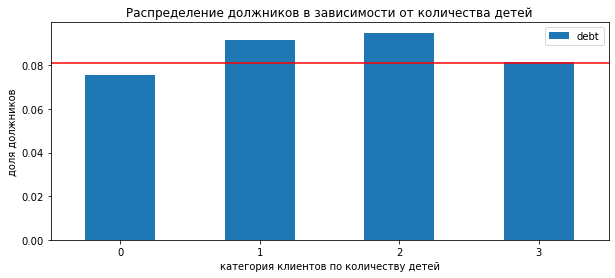

In [90]:
# Столбчатая диаграмма по распределению должников
rot = 0
figsize = (10, 4)

final_df_children.plot(kind='bar', rot=rot, figsize=figsize, title="Распределение должников в зависимости от количества детей").set(
    xlabel='категория клиентов по количеству детей', 
    ylabel="доля должников")
plt.axhline(y=total_debt, color='r', linestyle='-')
plt.show()

**Вывод**

Сравнение клиентов с разным количеством детей показало, что:
- **процент должников по кредиту выше всего в категории клиентов, имеющих два ребенка**: `9.49%` от всех клиентов с двумя детьми; 
- далее со значением в `9.17%` должников идут **клиенты с одним ребенком**;
- **у многодетных клиентов** процент должников составил `8.16%`. 


- Исследование показывает, что **самыми ответственными клиентами являются бездетные**, их процент должников составил `7.54%`.


### Есть ли зависимость между семейным положением и возвратом кредита в срок?

По аналогии с выявлением зависимости между количеством детей и возвратом кредита в срок, подсчитаем количество должников в каждой категории клиентов.

In [91]:
# Вывод данных в таблице по возрастанию процента должников
final_df_family = pd.DataFrame(df.groupby('family_status_id')['debt'].mean())
final_df_family = final_df_family.merge(df_family, on='family_status_id').drop(columns=['family_status_id'])
with pd.option_context('display.float_format','{:.2%}'.format):
    display(final_df_family.sort_values(by='debt'))

,debt,family_status
2,6.57%,вдовец / вдова
3,7.11%,в разводе
0,7.55%,женат / замужем
1,9.35%,гражданский брак
4,9.75%,не женат / не замужем


Отобразим данные значения на столбчатой диаграмме. Горизонтальной линией отобразим долю должников от всех клиентов.

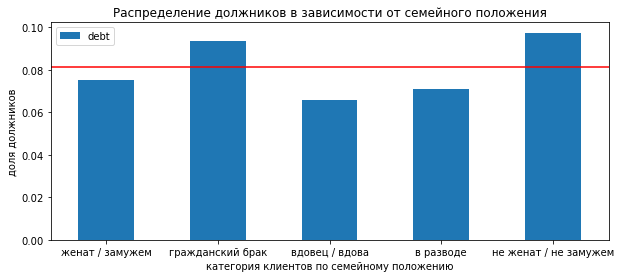

In [92]:
# Столбчатая диаграмма по распределению должников
final_df_family.plot(kind='bar', rot=rot, figsize=figsize, x='family_status', title="Распределение должников в зависимости от семейного положения").set(
    xlabel='категория клиентов по семейному положению', 
    ylabel="доля должников")
plt.axhline(y=total_debt, color='r', linestyle='-')
plt.show()

**Вывод**

**Наиболее безответственными** в плане выплата кредитов оказались клиенты, **не состоящие и не состоявшие в официальных отношениях**:
- **максимальный процент должников** зафиксирован среди **не женатых и не замужних клиентов** - `9.75%`;
- чуть меньший процент должников у клиентов, **живущих в гражданском браке** - `9.35%`.

Клиенты, находящиеся или находившиеся ранее **в официальных отношениях** оказались **более ответственны**:
- **женатые и замужние** клиенты оказались должниками в `7.55%` случаев;
- клиенты, находящиеся в разводе - в `7.11%` случаев;


- **самыми ответственными клиентами** являются те, кто потерял своего партнера: **среди вдовцов и вдов самый низкий процент должников**, он составляет `6.57%`.

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

По аналогии с выявлением зависимости между количеством детей и возвратом кредита в срок, подсчитаем количество должников в каждой категории клиентов.

In [93]:
# Вывод данных в таблице по возрастанию процента должников
final_df_income = df.groupby(by='income_id')['debt'].mean()
with pd.option_context('display.float_format','{:.2%}'.format):
    display(final_df_income.sort_values())

income_id
0   6.08%
4   7.07%
1   8.34%
3   8.49%
2   8.69%
Name: debt, dtype: float64

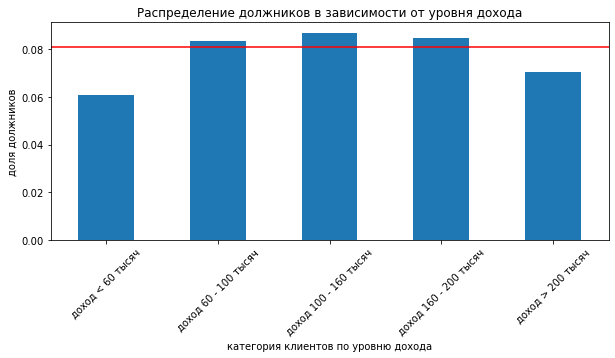

In [94]:
# Столбчатая диаграмма по распределению должников
final_df_income.plot(kind='bar', rot=45, figsize=figsize, title="Распределение должников в зависимости от уровня дохода").set(
    xlabel='категория клиентов по уровню дохода', 
    ylabel="доля должников")
income_category_list = ['доход < 60 тысяч', 
                        'доход 60 - 100 тысяч', 
                        'доход 100 - 160 тысяч', 
                        'доход 160 - 200 тысяч',
                        'доход > 200 тысяч']
plt.xticks([0, 1, 2, 3, 4], income_category_list)

plt.axhline(y=total_debt, color='r', linestyle='-')
plt.show()

**Вывод**

- В целом клиенты с уровнем дохода от 60 до 200 тысяч показали себя не очень ответственными в плане выплаты кредита.
- **Наибольшее количество должников** наблюдается среди клиентов, зарабатывающих **100-160 тысяч** - `8.69%`.
- **Самыми ответственными** оказались клиенты с доходом **ниже 60 тысяч** - `6.08%`.

### Как разные цели кредита влияют на его возврат в срок?

По аналогии с выявлением зависимости между количеством детей и возвратом кредита в срок, подсчитаем количество должников в каждой категории клиентов.

In [95]:
# Вывод данных в таблице по возрастанию процента должников
final_df_purpose = df.groupby('purpose')['debt'].mean()
with pd.option_context('display.float_format','{:.2%}'.format):
    display(final_df_purpose.sort_values())

purpose
недвижимость   7.23%
свадьба        8.00%
образование    9.22%
автомобиль     9.36%
Name: debt, dtype: float64

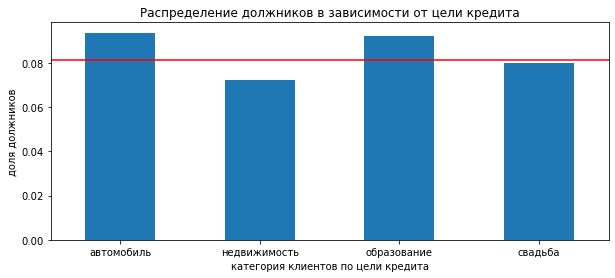

In [96]:
# Столбчатая диаграмма по распределению должников
final_df_purpose.plot(kind='bar', rot=rot, figsize=figsize, title="Распределение должников в зависимости от цели кредита").set(
    xlabel='категория клиентов по цели кредита', 
    ylabel="доля должников")
plt.axhline(y=total_debt, color='r', linestyle='-')
plt.show()

**Вывод**

- Клиентами с **самым высоким процентом должников** в категории оказались те, кто брал кредит на **автомобиль** - `9.36%`.
- Далее следуют клиенты, желающие получить **образование** - `9.22%`.
- Среди тех, кто брал кредит на **свадьбу**, задолженность по кредиту имели `8.00%` клиентов.
- **Самыми ответственными клиентами** являются те, кто брал кредит на операции с **недвижимостью** - всего `7.23%`.

## Шаг 4. Общий вывод

В результате исследования были выявлены **более перспективные категории клиентов с точки зрения возврата кредита**:
- бездетные и многодетные; 
- вдовцы и вдовы, в разводе или женатые / замужние; 
- с доходом ниже 60 тысяч или выше 200 тысяч;
- взявшие кредит на недвижимость или свадьбу.

**Самые опасные клиенты**, среди которых процент должников выше всего:
- клиенты с одним или двумя детьми;
- не женатые / не замужние, либо живущие в гражданском браке;
- с доходом 60-200 тысяч;
- взявшие кредит на автомобиль или образование.
